## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [2]:
import warnings
warnings.filterwarnings('ignore')
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
import string
from pymorphy2 import MorphAnalyzer
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

In [3]:
stops = set(stopwords.words('russian')) | {'gt',}
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def normalize(words):
    norm_words = [morph.parse(word)[0].normal_form for word in words if len(set(word)) > 1]
    return norm_words

def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word)[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation+'«»') for word in text.split()]
    words = [word for word in words if word]
    
    return words

## Возьмем те же данные

In [4]:
habr_texts = opt_normalize([tokenize(remove_tags(text.lower())) for text in open('habr_texts.txt')])

In [5]:
#вернемся сюда через какое-то время
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [6]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(ngrammed_habr_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x.replace(':', '')+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [7]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    return model_artm.score_tracker['PerplexityScore'].last_value

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [8]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                        batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [9]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [10]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [11]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=19038663-855b-491f-b44f-1c911398e7dc, num_entries=10759)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [12]:
dictionary.save_text('dict.txt')

### 4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается)

In [13]:
import pandas as pd

In [14]:
with open('dict.txt', 'r') as file:
    objs = file.read().splitlines() 

In [15]:
only_words = objs[2:]

In [16]:
s = pd.Series(only_words)

In [17]:
df_dict = s.str.split(", ", expand=True)

In [18]:
objs[1]

'token, class_id, token_value, token_tf, token_df'

In [19]:
df_dict.head()

,0,1,2,3,4
0,новое,@default_class,0.0009072927059605718,2548.0,1414.0
1,стоимость,@default_class,0.0002923419524449855,821.0,426.0
2,дорогой,@default_class,0.0001449246919946745,407.0,294.0
3,выбирать,@default_class,0.00026527984300628304,745.0,514.0
4,остаться_прежний,@default_class,6.409446086763637e-06,18.0,15.0


In [20]:
df_dict.shape

(10759, 5)

##### Что плохого в словаре:

    1) частотные слова - в начале мы убрали русские стоп-слова, ещё хотелось бы убрать частотные английские слова - тоже встречаются
    2) ссылки: "lt;/button&gt", "lt;/script&gt"
    3) отдельные буквы "f"
    4) некоторые слова плохо отсоединены от кавычек (в начале это можно исправить, только не здесь, так как это повлияет на tf-idf): "«зелёный" - исправила при токенизации
    5) знаки препинания стоит убрать (убираются, когда длина слова = 1)

1) удаляем частотные английские слова

In [21]:
df_dict = df_dict[~df_dict[0].isin(stopwords.words('english'))]

In [22]:
df_dict.shape# Да, там были стоп-слова из английского

(10702, 5)

2) отдельные буквы (заодно здесь убираются и знаки препинания)

In [23]:
df_dict = df_dict[df_dict[0].map(len) != 1]

In [24]:
df_dict.shape

(10665, 5)

3) ссылки

In [25]:
df_dict = df_dict[~df_dict[0].str.contains(r'lt;/')]

In [26]:
df_dict.shape

(10661, 5)

In [27]:
#сохраняет новый словарь
np.savetxt('changed_dict.txt', df_dict.values, fmt='%s', delimiter=", ", header=objs[0]+'\n'+objs[1], comments='')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [28]:
# здесь просто смотрю, как работает на старом словаре

In [29]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [30]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [31]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [32]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 2961.888 (ARTM)


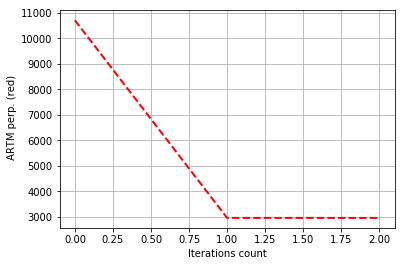

2961.8876953125

In [33]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [34]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [35]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [36]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.5))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.799 (ARTM)
Sparsity Theta: 0.174 (ARTM)
Kernel contrast: 0.283 (ARTM)
Kernel purity: 0.194 (ARTM)
Perplexity: 1720.496 (ARTM)


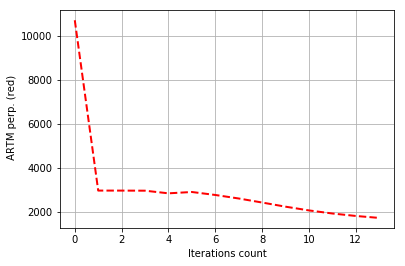

1720.496337890625

In [37]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

### 5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем;

In [38]:
def grid(batch_vectorizer,
         dictionary,
         num_topics=200,
         tau_smooth=0.25,
         tau_sparse=-0.15,
         n_epochs=10,
         n_doc_passes=2,
         sparse_phi=False, 
         sparse_theta=False):
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(num_topics)],
                           regularizers=[
                               artm.DecorrelatorPhiRegularizer(
                                   name='Decorr',
                                   tau=tau_smooth,
                                   class_ids=['@default_class'],
                                   topic_names=['topic_{}'.format(i) for i in range(1, num_topics)]),
                               artm.SmoothSparsePhiRegularizer(
                                   name='SmoothPhi_1', 
                                   class_ids=['@default_class'],
                                   tau=tau_smooth, 
                                   topic_names=['topic_{}'.format(i) for i in range(0, num_topics)])])

    model_artm.num_document_passes = n_doc_passes
    model_artm.initialize(dictionary=dictionary, )
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

    if sparse_phi:
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=tau_sparse, 
                                                                topic_names=['topic_{}'.format(i) for i in range(1, num_topics)],
                                                                ))
        phi_tau = model_artm.regularizers['SparsePhi'].tau
    if sparse_theta:
        model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=tau_sparse, 
                                                                  topic_names=['topic_{}'.format(i) for i in range(1, num_topics)]))
        theta_tau = model_artm.regularizers['SparseTheta'].tau
                          
    for i in range(n_epochs):
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                               num_collection_passes=1)
        if sparse_phi:
            model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
        if sparse_theta:
            model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.5))

    perplexity = print_measures(model_artm)
    return perplexity, model_artm

1. Улучшение словаря (словарь исправлялся выше)

In [ ]:
# импортируем наш новый словарь
dictionary = artm.Dictionary()
dictionary.load_text('changed_dict.txt')

In [ ]:
perplexity, model_artm = grid(batch_vectorizer=batch_vectorizer,
                  dictionary=dictionary,
                  sparse_phi=True, 
                  sparse_theta=True)

##### Улучшение словаря увеличило перплексию, хотя странно, так как я убирала только мусор (стопслова, знаки препинания, отдельные буквы и странные ссыылки. Возможно перебор параметров улучшит качество модели.

2. Изменение параметров:
    ```
    количество тем = [50, 200, 300]
    tau ('Decorr', 'SmoothPhi_1') = [0.15, 1.0, 1e+5] - tau > 0 leads to smoothing, tau < 0 to sparsing
    num_passes = [2, 5, 10]
    tau ('SparsePhi', 'SparseTheta') = [-0.15, -0.1, -0.5]
    ```

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
num_topics = [50, 200, 300]
tau_smooth = [0.15, 1.0, 1e+5]
num_passes = [1, 3, 5]
tau_sparse = [-0.15, -0.1, -0.5]
#по сетке перебор большой: сделаем tau_smooth1 = tau_smooth2 и tau_sparse1 = tau_sparse2
res = []
for t in tqdm(num_topics):
    for tau_sm in tqdm(tau_smooth):
        for tau_sp in tqdm(tau_sparse):
            for p in tqdm(num_passes):
                for sp in [True, False]:
                    perplexity, model_artm = grid(batch_vectorizer=batch_vectorizer,
                                                  dictionary=dictionary,
                                                  num_topics=t,
                                                  tau_smooth=tau_sm,
                                                  tau_sparse=tau_sp,
                                                  n_epochs=20,
                                                  n_doc_passes=p,
                                                  sparse_phi=sp, 
                                                  sparse_theta=sp)
                    res.append([t, tau_sm, tau_sp, p, sp, perplexity])

### 6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

Найдём лучшую модель:

In [ ]:
import operator

In [ ]:
res.sort(key=operator.itemgetter(5))

In [ ]:
res

In [ ]:
perplexity, model_artm = grid(batch_vectorizer=batch_vectorizer,
                              dictionary=dictionary,
                              num_topics=res[0],
                              tau_smooth=res[1],
                              tau_sparse=res[2],
                              n_epochs=20,
                              n_doc_passes=res[3],
                              sparse_phi=res[4], 
                              sparse_theta=res[4])

In [ ]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:20]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

Мне кажется темы вышли 

### 7) в другой ячейке нарисуйте график обучения этой модели

In [ ]:
perplexity = print_measures(model_artm)

### 8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

In [ ]:
Параметры, которые перебирались указаны выше. 